# Imports

In [116]:
import numpy as np
import matplotlib.pyplot as plt


from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, log_loss, accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense,Flatten,GlobalAveragePooling2D,Conv2D,MaxPooling2D,Activation,Dropout


import warnings
warnings.filterwarnings('ignore')

from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, CarliniLInfMethod, DeepFool, ProjectedGradientDescent
from art.attacks.evasion import FeatureAdversariesTensorFlowV2
from art.estimators.classification import TensorFlowV2Classifier
if tf.__version__[0] != '2':
    raise ImportError('This notebook requires TensorFlow v2.')
tf.compat.v1.disable_eager_execution()

In [117]:
lfw_dataset=fetch_lfw_people(min_faces_per_person=100)

print(lfw_dataset.images.shape)
print(lfw_dataset.data.shape)
print(lfw_dataset.target_names.shape)
print(lfw_dataset.target.shape)

lfw_dataset.target

Name = lfw_dataset.target_names

print(Name)
print(len(Name))

N=[]
for i in range(len(Name)):
    N+=[i]

mapping=dict(zip(Name,N))
reverse_mapping=dict(zip(N,Name))

def mapper(value):
    return reverse_mapping[value]

X0=lfw_dataset.images
y=lfw_dataset.target

print(X0.shape)
X=X0.reshape(-1,62,47,1)
print(X.shape)

dataset=[]
testset=[]
t=0
for Xi,yi in zip(X,y):
    img=Xi/255.0
    if t<=200:
        dataset.append([img,yi])
    else:
        testset.append([img,yi])
    t+=1

data,labels0=zip(*dataset)
test,tlabels0=zip(*testset)

labels1=to_categorical(labels0)
data=np.array(data)
labels=np.array(labels1)

tlabels1=to_categorical(tlabels0)
test=np.array(test)
tlabels=np.array(tlabels1)

# trainx,testx,trainy,testy=train_test_split(data,labels,test_size=0.2,random_state=44)
trainx,testx,trainy,testy=train_test_split(data,labels,test_size=0.2,random_state=1)

x_train = trainx.astype(np.float32)
x_test = testx.astype(np.float32)
y_train = trainy.astype(np.float32)
y_test = testy.astype(np.float32)

print(trainx.shape)
print(testx.shape)
print(trainy.shape)

(1140, 62, 47)
(1140, 2914)
(5,)
(1140,)
['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']
5
(1140, 62, 47)
(1140, 62, 47, 1)
(160, 62, 47, 1)
(41, 62, 47, 1)
(160, 5)


In [165]:
def plot_gallery(images, titles, h=62, w=47, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    # plt.figure.patch.set_facecolor('white')
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i+1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(Name[np.argmax(titles[i])], size=12)
        plt.xticks(())
        plt.yticks(())

def plot_image(image, title):
    """Helper function to plot a gallery of portraits"""
    plt.matshow(image, cmap=plt.cm.gray)
    plt.title(Name[np.argmax(title)], size=12)
    plt.xticks(())
    plt.yticks(())

In [141]:
from art.attacks.evasion import FeatureAdversariesTensorFlowV2
from art.estimators.classification import TensorFlowV2Classifier
from art.utils import load_mnist

model = Sequential()
model.add(Conv2D(32,(3,3), input_shape=(62,47,1), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32,(3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=5, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Step 2a: Define the loss function and optimizer

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

def train_step(model, images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

# model = keras.models.load_model("VGG_model_87.pth")
# datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=20,zoom_range=0.2,
#                     width_shift_range=0.2,height_shift_range=0.2,shear_range=0.1,fill_mode="nearest")
#
# # model.fit(trainx,trainy, validation_data=(testx,testy),epochs=100, batch_size=32)
# his=model.fit(datagen.flow(trainx,trainy,batch_size=32),validation_data=(testx,testy),epochs=1000)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 60, 45, 32)        320       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 30, 22, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 28, 20, 32)        9248      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 14, 10, 32)       0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 4480)              0         
                                                                 
 dense_21 (Dense)            (None, 512)              

In [142]:
model.fit(x_train, y_train, validation_data=(testx,testy), epochs=300, batch_size=64)

Train on 160 samples, validate on 41 samples


2023-05-24 20:35:09.677203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-24 20:35:09.750658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/300
 64/160 [===========>..................] - ETA: 0s - loss: 1.6564 - accuracy: 0.1094

2023-05-24 20:35:09.889694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-24 20:35:09.903461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


160/160 [==============================] - 0s 3ms/sample - loss: 1.4690 - accuracy: 0.3500 - val_loss: 1.6900 - val_accuracy: 0.1463
Epoch 2/300
160/160 [==============================] - 0s 708us/sample - loss: 1.4555 - accuracy: 0.3625 - val_loss: 1.4415 - val_accuracy: 0.4390
Epoch 3/300


2023-05-24 20:35:10.224546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


160/160 [==============================] - 0s 465us/sample - loss: 1.3742 - accuracy: 0.4750 - val_loss: 1.4766 - val_accuracy: 0.4390
Epoch 4/300
160/160 [==============================] - 0s 537us/sample - loss: 1.3851 - accuracy: 0.4750 - val_loss: 1.4874 - val_accuracy: 0.4390
Epoch 5/300
160/160 [==============================] - 0s 630us/sample - loss: 1.3570 - accuracy: 0.4750 - val_loss: 1.4749 - val_accuracy: 0.4390
Epoch 6/300
160/160 [==============================] - 0s 448us/sample - loss: 1.3464 - accuracy: 0.4750 - val_loss: 1.4100 - val_accuracy: 0.4878
Epoch 7/300
160/160 [==============================] - 0s 456us/sample - loss: 1.3389 - accuracy: 0.4875 - val_loss: 1.3788 - val_accuracy: 0.4390
Epoch 8/300
160/160 [==============================] - 0s 446us/sample - loss: 1.3067 - accuracy: 0.4750 - val_loss: 1.4027 - val_accuracy: 0.4390
Epoch 9/300
160/160 [==============================] - 0s 463us/sample - loss: 1.2817 - accuracy: 0.4813 - val_loss: 1.4196 - val_

In [143]:
loss_test, accuracy_test = model.evaluate(x_test, y_test)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy on test data: 85.37%


In [144]:
classifier = KerasClassifier(model=model, clip_values=(0, 1))

In [145]:
import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from art.attacks.poisoning.poisoning_attack_svm import PoisoningAttackSVM
from art.estimators.classification.scikitlearn import ScikitlearnSVC
from art.defences.detector.poison import ProvenanceDefense, RONIDefense
from art.utils import load_mnist
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(301)

import warnings
warnings.filterwarnings('ignore')
from __future__ import absolute_import, division, print_function, unicode_literals

import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.get_logger().setLevel('ERROR')

from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor, PoisoningAttackCleanLabelBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd
from art.utils import load_mnist, preprocess, to_categorical
from art.defences.trainer import AdversarialTrainerMadryPGD


from art.estimators.classification.deep_partition_ensemble import DeepPartitionEnsemble

In [146]:
def attack(model, attack, x, y):
    x_adv = attack.generate(x)
    loss, accuracy = model.evaluate(x_adv, y)
    print('Accuracy on adversarial test examples: {}%'.format(accuracy * 100))
    return x_adv

In [147]:
x_adv = attack(model, FastGradientMethod(estimator=classifier, eps=1/255), x_test, y_test)

Accuracy on adversarial test examples: 73.17073345184326%


2023-05-24 20:35:32.272502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-24 20:35:32.332690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [155]:
accuracy_fgsm = []
eps = np.linspace(1e-3, 20/255, 20)
for _eps in eps:
    x_adv = attack(model, DeepFool(classifier, epsilon=_eps, batch_size=32, max_iter=1, nb_grads=1), x_train, y_train)
    loss, accuracy = model.evaluate(x_adv, y_train)
    accuracy_fgsm.append(accuracy)

DeepFool:   0%|          | 0/5 [00:00<?, ?it/s]

2023-05-24 20:43:21.071656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-24 20:43:21.218389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-24 20:43:21.350474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-24 20:43:21.482946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-24 20:43:21.644044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Accuracy on adversarial test examples: 5.625000223517418%


DeepFool:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 5.625000223517418%


DeepFool:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 5.625000223517418%


DeepFool:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 5.625000223517418%


DeepFool:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 5.625000223517418%


DeepFool:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 5.625000223517418%


DeepFool:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 5.625000223517418%


DeepFool:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 5.625000223517418%


DeepFool:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 5.625000223517418%


DeepFool:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 5.625000223517418%


DeepFool:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 5.625000223517418%


DeepFool:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 5.625000223517418%


DeepFool:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 5.625000223517418%


DeepFool:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 5.625000223517418%


DeepFool:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 5.625000223517418%


DeepFool:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 5.625000223517418%


DeepFool:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 5.625000223517418%


DeepFool:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 5.000000074505806%


DeepFool:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 5.000000074505806%


DeepFool:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 5.000000074505806%


DeepFool:   0%|          | 0/160 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 1.2500000186264515%


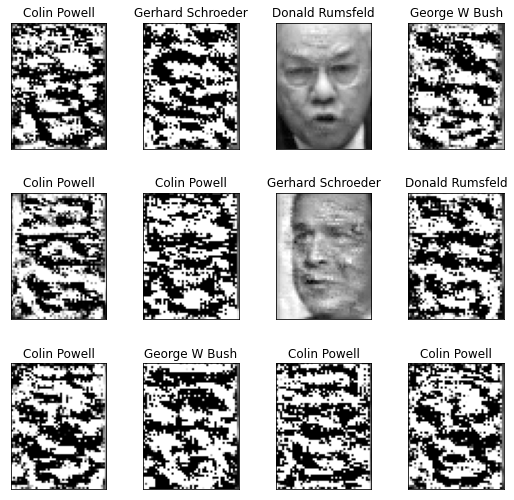

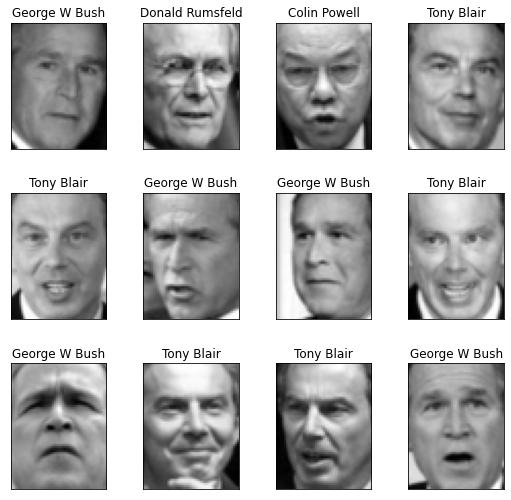

In [166]:
x_adv = attack(model, DeepFool(classifier, epsilon=1/255), x_train, y_train)
plot_gallery(x_adv, model.predict(x_adv))
plot_gallery(x_train, y_train)

In [ ]:
x_adv.shape

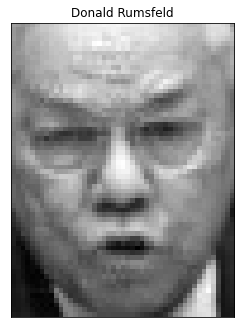

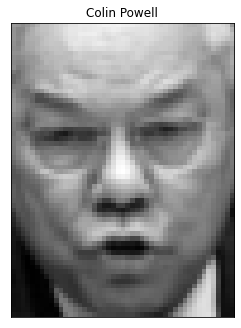

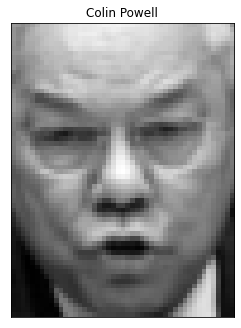

In [170]:
plot_image(x_adv[2], model.predict(x_adv)[2])
plot_image(x_train[2], model.predict(x_train)[2])
plot_image(x_train[2], y_train[2])

In [150]:
accuracy_fgsm = []
eps = np.linspace(1e-3, 20/255, 20)
for _eps in eps:
    x_adv = attack(model, FastGradientMethod(estimator=classifier, eps=_eps), x_train, y_train)
    loss, accuracy = model.evaluate(x_adv, y_train)
    accuracy_fgsm.append(accuracy)

DeepFool:   0%|          | 0/5 [00:00<?, ?it/s]

2023-05-24 20:36:08.465034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Accuracy on adversarial test examples: 1.2500000186264515%


DeepFool:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 1.2500000186264515%


DeepFool:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 1.2500000186264515%


DeepFool:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 1.2500000186264515%


DeepFool:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 1.2500000186264515%


DeepFool:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 1.2500000186264515%


DeepFool:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 1.2500000186264515%


DeepFool:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 1.2500000186264515%


DeepFool:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 1.2500000186264515%


DeepFool:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 1.2500000186264515%


DeepFool:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 1.2500000186264515%


DeepFool:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 1.2500000186264515%


DeepFool:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 1.2500000186264515%


DeepFool:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 1.2500000186264515%


DeepFool:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 1.2500000186264515%


DeepFool:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 1.2500000186264515%


DeepFool:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 1.2500000186264515%


DeepFool:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 1.2500000186264515%


DeepFool:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 1.2500000186264515%


DeepFool:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 1.2500000186264515%


In [156]:
def plot(x, y, label, xlabel="eps", ylabel="accuracy"):
    fig, ax = plt.subplots()
    ax.plot(x, y, label=label)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    fig.patch.set_facecolor('white')
    plt.show()

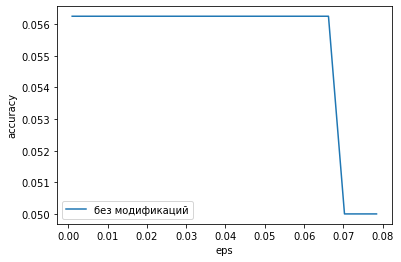

In [157]:
plot(eps, accuracy_fgsm, label="без модификаций")

In [133]:
# modify train data with fgsm attack and retrain the model
x_adv = []
y_adv_true = []
k = 1
x_train_adv = attack(model, FastGradientMethod(estimator=classifier, eps=5/255), x_train[::k, :], y_train[::k, :])
y_adv_true.append(y_train[::k, :])
x_adv.append(x_train_adv)
k = 3
x_train_adv = attack(model, ProjectedGradientDescent(estimator=classifier, eps=8/255), x_train[::k, :], y_train[::k, :])
y_adv_true.append(y_train[::k, :])
x_adv.append(x_train_adv)
# x_train_adv = attack(model, FastGradientMethod(estimator=classifier, eps=0.04), x_train[::4, :], y_train[::4, :])
# y_adv_true.append(y_train[::4, :])
# x_adv.append(x_train_adv)

Accuracy on adversarial test examples: 33.75000059604645%


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 14.814814925193787%


In [134]:
x_add_adv_data = np.array(x_train)
y_add_adv_data = np.array(y_train)
for i in range(len(x_adv)):
    x_add_adv_data = np.append(x_add_adv_data, x_adv[i]).reshape(-1, 62, 47, 1)
    y_add_adv_data = np.append(y_add_adv_data, y_adv_true[i]).reshape(-1, 5)

In [135]:
trainx_adv,testx_adv,trainy_adv,testy_adv=train_test_split(x_add_adv_data,y_add_adv_data,test_size=0.2,random_state=1)

In [136]:
# x_add_adv_data = np.append(x_train, x_train_adv).reshape(-1, 62, 47, 1)
# y_add_adv_data = np.append(y_train, y_train[::3, :]).reshape(-1, 5)
x_add_adv_data.shape, y_add_adv_data.shape

((374, 62, 47, 1), (374, 5))

In [137]:
model.fit(trainx_adv,trainy_adv, validation_data=(testx_adv,testy_adv),epochs=20, batch_size=32)

Train on 299 samples, validate on 75 samples
Epoch 1/20
299/299 [==============================] - 0s 1ms/sample - loss: 3.6550 - accuracy: 0.4181 - val_loss: 1.5536 - val_accuracy: 0.4933
Epoch 2/20
299/299 [==============================] - 0s 627us/sample - loss: 1.4497 - accuracy: 0.4849 - val_loss: 1.4416 - val_accuracy: 0.4933
Epoch 3/20
299/299 [==============================] - 0s 639us/sample - loss: 1.3943 - accuracy: 0.4849 - val_loss: 1.4138 - val_accuracy: 0.4933
Epoch 4/20
299/299 [==============================] - 0s 714us/sample - loss: 1.3728 - accuracy: 0.4849 - val_loss: 1.4077 - val_accuracy: 0.4933
Epoch 5/20
299/299 [==============================] - 0s 585us/sample - loss: 1.3584 - accuracy: 0.4849 - val_loss: 1.4036 - val_accuracy: 0.4933
Epoch 6/20
299/299 [==============================] - 0s 598us/sample - loss: 1.3401 - accuracy: 0.4849 - val_loss: 1.3730 - val_accuracy: 0.4933
Epoch 7/20
299/299 [==============================] - 0s 588us/sample - loss: 1.2

In [44]:
model.fit(x_add_adv_data,y_add_adv_data, validation_data=(testx,testy),epochs=10, batch_size=32)

Train on 320 samples, validate on 41 samples
Epoch 1/10
320/320 [==============================] - 0s 1ms/sample - loss: 0.6714 - accuracy: 0.7812 - val_loss: 1.2330 - val_accuracy: 0.7073
Epoch 2/10
320/320 [==============================] - 0s 1ms/sample - loss: 0.4068 - accuracy: 0.8469 - val_loss: 0.8140 - val_accuracy: 0.7561
Epoch 3/10
320/320 [==============================] - 0s 962us/sample - loss: 0.1890 - accuracy: 0.9344 - val_loss: 0.6410 - val_accuracy: 0.8049
Epoch 4/10
320/320 [==============================] - 0s 963us/sample - loss: 0.0782 - accuracy: 0.9812 - val_loss: 0.9697 - val_accuracy: 0.7805
Epoch 5/10
320/320 [==============================] - 0s 1ms/sample - loss: 0.0576 - accuracy: 0.9875 - val_loss: 0.5345 - val_accuracy: 0.8293
Epoch 6/10
320/320 [==============================] - 0s 878us/sample - loss: 0.0364 - accuracy: 0.9938 - val_loss: 0.6749 - val_accuracy: 0.7805
Epoch 7/10
320/320 [==============================] - 0s 1ms/sample - loss: 0.0270 - 

In [54]:
model.fit(x_train, y_train, validation_data=(testx,testy), epochs=300, batch_size=64)

Train on 160 samples, validate on 41 samples
Epoch 1/300
160/160 [==============================] - 0s 709us/sample - loss: 1.7377e-04 - accuracy: 1.0000 - val_loss: 2.3079 - val_accuracy: 0.6585
Epoch 2/300
160/160 [==============================] - 0s 555us/sample - loss: 1.7143e-04 - accuracy: 1.0000 - val_loss: 2.3091 - val_accuracy: 0.6585
Epoch 3/300
160/160 [==============================] - 0s 672us/sample - loss: 1.6904e-04 - accuracy: 1.0000 - val_loss: 2.3098 - val_accuracy: 0.6585
Epoch 4/300
160/160 [==============================] - 0s 910us/sample - loss: 1.6658e-04 - accuracy: 1.0000 - val_loss: 2.3104 - val_accuracy: 0.6585
Epoch 5/300
160/160 [==============================] - 0s 766us/sample - loss: 1.6429e-04 - accuracy: 1.0000 - val_loss: 2.3112 - val_accuracy: 0.6585
Epoch 6/300
160/160 [==============================] - 0s 661us/sample - loss: 1.6215e-04 - accuracy: 1.0000 - val_loss: 2.3145 - val_accuracy: 0.6585
Epoch 7/300
160/160 [============================

In [138]:
accuracy_fgsm_after_modification = []
eps = np.linspace(1e-4, 20/255, 20)
for _eps in eps:
    x_adv = attack(model, FastGradientMethod(estimator=classifier, eps=_eps), x_train, y_train)
    loss, accuracy = model.evaluate(x_adv, y_train)
    accuracy_fgsm_after_modification.append(accuracy)

Accuracy on adversarial test examples: 100.0%
Accuracy on adversarial test examples: 99.37500357627869%
Accuracy on adversarial test examples: 93.12500357627869%
Accuracy on adversarial test examples: 80.62500357627869%
Accuracy on adversarial test examples: 63.12500238418579%
Accuracy on adversarial test examples: 47.49999940395355%
Accuracy on adversarial test examples: 32.50000178813934%
Accuracy on adversarial test examples: 24.375000596046448%
Accuracy on adversarial test examples: 18.125000596046448%
Accuracy on adversarial test examples: 15.000000596046448%
Accuracy on adversarial test examples: 10.625000298023224%
Accuracy on adversarial test examples: 9.375%
Accuracy on adversarial test examples: 7.500000298023224%
Accuracy on adversarial test examples: 6.25%
Accuracy on adversarial test examples: 5.000000074505806%
Accuracy on adversarial test examples: 4.374999925494194%
Accuracy on adversarial test examples: 3.750000149011612%
Accuracy on adversarial test examples: 3.750000

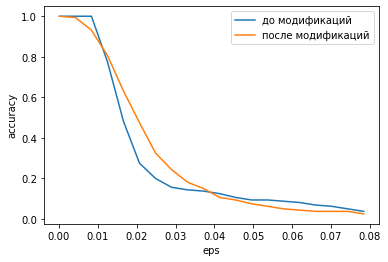

In [139]:
fig, ax = plt.subplots()
ax.plot(eps, accuracy_fgsm, label='до модификаций')
ax.plot(eps, accuracy_fgsm_after_modification, label='после модификаций')
ax.set_xlabel('eps')
ax.set_ylabel('accuracy')
ax.legend()
fig.patch.set_facecolor('white')
plt.show()
# plt.savefig("Добавление модифицированных данных атаки с eps 0.02-0.031(Хороший результат).png", dpi=300, bbox_inches='tight')

In [ ]:
plot_gallery(x_adv, model.predict(x_adv))

In [ ]:
plot_gallery(x_train, y_train)